In [1]:
import numpy as np
import matplotlib.pyplot as plt
from landlab import RasterModelGrid, FIXED_GRADIENT_BOUNDARY
from landlab.plot.imshow import imshow_grid
from matplotlib.pyplot import title, show, figure, plot, subplot, xlabel, ylabel

#### set

In [2]:
res = 100.0 # cell size
runtime = 60000*np.pi*10**7 # seconds
dt = 10*(10**5) #seconds
rho_ice = 917 # kg/m3
A = 2.1*(10**-16)/(np.pi*10**7)  # Arrhenius constant [Pa^-3 yr^-1]
N = 3 # shape factor from Glen's Flow Law
g = 9.81 # m/s2 gravitational acceleration
gamma = 0.01 # mass balance gradient [(m/yr)/m]
ela = 3000 # equilibrium line altitude [m]
center_slope = np.radians(20) # slope in degrees of the centerline
side_slope = np.radians(30) # slope in degrees of the valley walls
valley_elevation = 3000 # baseline elevation of the valley in meters

#### initialize

In [3]:
num_iterations = int(runtime / dt) # define number of iterations
rg = RasterModelGrid((21,80),res) #create basic grid, start big
rg.status_at_node[rg.boundary_nodes] = FIXED_GRADIENT_BOUNDARY
#rg.set_closed_boundaries_at_grid_edges(False, True, False, True)
z_bedrock = rg.add_zeros('node','bedrock_elevation') # bedrock elevations will be stored at nodes
h_ice = rg.add_zeros('node','ice_thickness') # ice thickness will be stored at nodes
mb = rg.add_zeros('node','mass_balance') # mass balance will be stored at nodes
centerline = rg.y_of_node.max()/2. # centerline is in the middle of the array
centerline_nodes = np.where(rg.y_of_node==centerline)[0] # find indices of all centerline nodes
# open book valley
#z_bedrock += valley_elevation+rg.x_of_node[centerline_nodes[0]]+rg.x_of_node*np.tan(center_slope)+abs(rg.y_of_node-rg.y_of_node[centerline_nodes[0]])*np.tan(side_slope)
# concave up valley with linear sides
z_bedrock += valley_elevation/2-0.2*rg.x_of_node+valley_elevation/2*np.exp(-rg.x_of_node/1500)+(abs(rg.y_of_node-rg.y_of_node[centerline_nodes[0]])**2)/1000
z_glacier = rg.add_field('node','glacier_elevation',z_bedrock.copy()) # copy bedrock elevations to glacier evelvation initially
ice_slope = rg.calc_grad_at_link(z_glacier)/res # slope of the ice stored at LINKS
h_edge = rg.add_zeros('link','cell_edge_thickness') #cell edge ice thickness - stored at LINKS
Q = rg.add_zeros('link','ice_flux') # ice flux stored at LINKS
dQdx = rg.add_zeros('node','net_ice_flux')# ice flux in and out of each node
dHdt = rg.add_zeros('node','ice_thickness_change') #rate of change of ice thickness

In [4]:
#print('length z_bedrock:nodes')
#print(len(z_bedrock))
#print('length h_ice: nodes')
#print(len(h_ice))
#print('length mb: nodes')
#print(len(mb))
#print('length z_glacier: nodes')
#print(len(z_glacier))
#print('length ice_slope: LINKS')
#print(len(ice_slope))
#print('length h_edge: LINKS')
#print(len(h_edge))
#print('length Q: node')
#print(len(Q))
#print('length dQdx: nodes')
#print(len(dQdx))
print('number of iterations')
print(num_iterations)

number of iterations
1884955


#### run model 

In [5]:
for i in range(num_iterations):
    ice_slope = rg.calc_grad_at_link(z_glacier)/res # slope of the ice stored at LINKS
    h_edge = rg.map_mean_of_link_nodes_to_link(h_ice) # calculate h_edge as average between nodes
    tau = rho_ice * g * h_edge * (-ice_slope)
    Q[rg.active_links] = (A/5.0) * (tau[rg.active_links]**N) * (h_edge[rg.active_links]**2)
    dQdx[:] = rg.calc_flux_div_at_node(Q)
    mb = gamma * (z_glacier - ela)/(np.pi*10**7)
    dHdt[rg.core_nodes] = mb[rg.core_nodes] - dQdx[rg.core_nodes]
    #dHdt[rg.core_nodes] = mb[rg.core_nodes] # accumulation only
    h_ice[rg.core_nodes] += dHdt[rg.core_nodes] * dt
    h_ice[h_ice < 0] = 0
    z_glacier[rg.core_nodes] = h_ice[rg.core_nodes] + z_bedrock[rg.core_nodes] # update ice elevation

#### plot

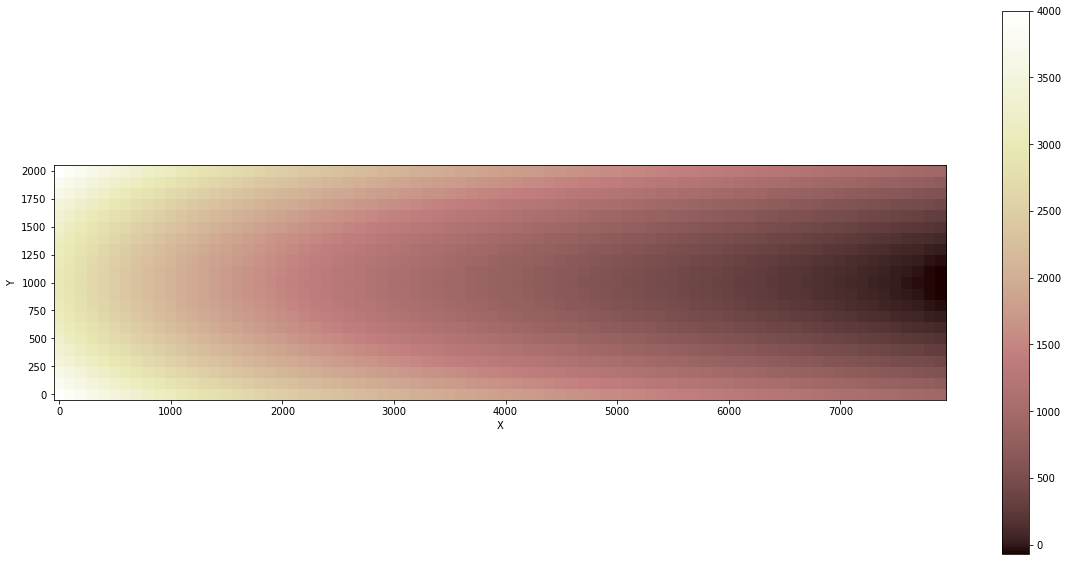

In [6]:
plt.figure(figsize=(20,10))
imshow_grid(rg, 'bedrock_elevation')

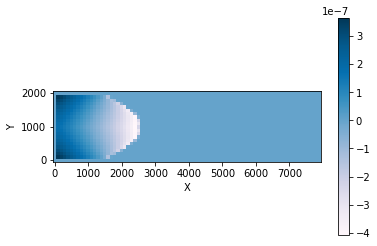

In [7]:
imshow_grid(rg, 'net_ice_flux',cmap='PuBu')

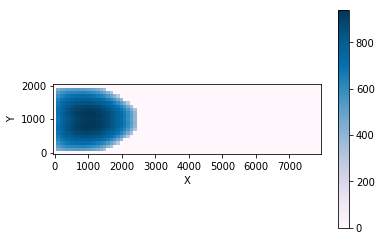

In [8]:
imshow_grid(rg, 'ice_thickness',cmap='PuBu')

In [9]:
from landlab.plot import channel_profile as prf
from landlab.components.flow_routing import FlowRouter
from landlab.components.stream_power import FastscapeEroder

Text(0,0.5,u'Elevation [m]')

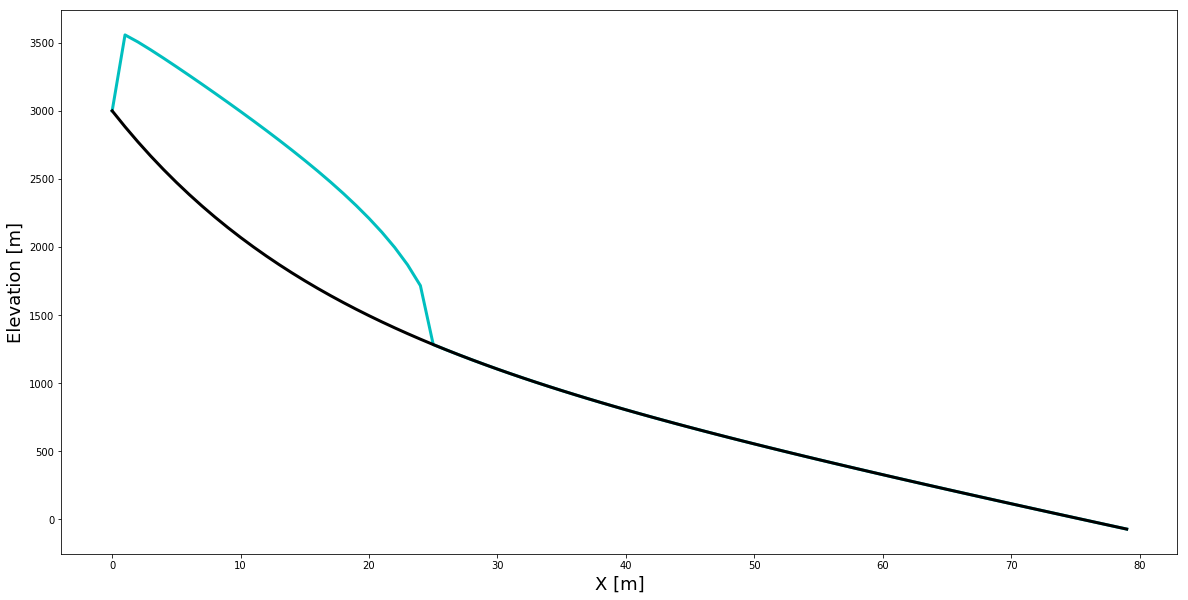

In [10]:
plt.figure(figsize=(20,10))
plt.plot(z_glacier[centerline_nodes],'c',linewidth=3.0)
plt.plot(z_bedrock[centerline_nodes],'k',linewidth=3.0)
plt.xlabel('X [m]',fontsize=18)
plt.ylabel('Elevation [m]',fontsize=18)